<a href="https://colab.research.google.com/github/moshemm/NN-methods-hse/blob/main/MLP_cedr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [191]:
!pip install datasets -q

In [192]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

We'll write a Multilayer Perceptrone, the dataset consists of Russian texts with emotion labels: {0: "joy", 1: "sadness", 2: "surprise", 3: "fear", 4: "anger"}. Let's consider only texts with one label

## Uploading and investigating the corpus (cedr from Transformers)

In [193]:
corpus = load_dataset('cedr')

corpus

No config specified, defaulting to: cedr/main
Reusing dataset cedr (/root/.cache/huggingface/datasets/cedr/main/0.1.1/117570489cbabbdf8de619bd31918a1cd680a7f286b89d04af340d0691dc2d66)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'source'],
        num_rows: 7528
    })
    test: Dataset({
        features: ['text', 'labels', 'source'],
        num_rows: 1882
    })
})

In [194]:
corpus['train'][:3]

{'labels': [[], [], [2]],
 'source': ['lj', 'lenta', 'lj'],
 'text': ['Суровый гималайский медведь .',
  'Так, обнаружено несколько проблем с дисплеем (выгорание, странные зеленые полосы), дефекты динамика и некорректная работа Face ID.',
  'У меня остается только один вопрос - является ли этот приступ отчаяния ( а точнее приступ удивления , почему мне не становится лучше , почему мне ничего не помогает ) еще одним испытанием ?']}

All possible labels

Text(0.5, 0, 'Emotions: {0: "joy", 1: "sadness", 2: "surprise", 3: "fear", 4: "anger"}')

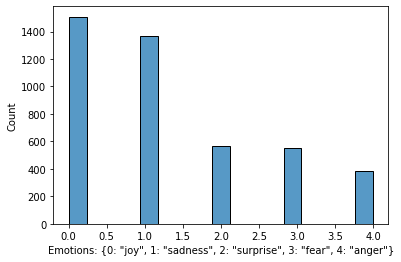

In [195]:
from collections import Counter

labels = [label[0] for label in corpus['train']['labels'] if len(label) == 1]
cnt_labels = Counter(labels)

sns.histplot(labels);
plt.xlabel('Emotions: {0: "joy", 1: "sadness", 2: "surprise", 3: "fear", 4: "anger"}')

We may say that classes are not balanced. We cannot use Accuracy as metrics. Let's see how it will affect out results - and it will affect, as there is very few inctances of 'surprise', 'fear' and 'anger' conpared to 'joy' and 'safness'.

In [196]:
texts = list()
labels = list()

for text, label in zip(corpus['train']['text'], corpus['train']['labels']):
    if len(label) == 1:
        texts.append(text)
        labels.append(label[0])
        
len(texts)

4378

## Data preprocessing

In [197]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize, ToktokTokenizer
from tqdm import tqdm

In [198]:
def preprocess(text):
    tokens = wordpunct_tokenize(text.lower())
    return tokens


vocab = Counter()

for text in texts:
    vocab.update(preprocess(text))
print('всего уникальных токенов:', len(vocab))

всего уникальных токенов: 15690


In [199]:
filtered_vocab = set()

for word in vocab:
  if vocab[word] > 2:
    filtered_vocab.add(word)

print(f'Токенов которые встречаются больше 2 раз: {len(filtered_vocab)}')

Токенов которые встречаются больше 2 раз: 2481


A lot of unique and rare tokens

In [200]:
word2id = {
    'PAD': 0,
    'UNK': 1}

for word in filtered_vocab:
  word2id[word] = word2id.get(word, len(word2id))

print(len(word2id))

2483


In [201]:
id2word = {i:word for word, i in word2id.items()}

In [202]:
id2word[3]

'денег'

In [203]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

### Lets see various tokenizers and how they impact our data preprocessing

#### NLTK: wordpunct_tokenize

In [204]:
total_n_words = 0
unknown_words = list()

for sample in tqdm(texts):
    # токенизация
    tokens = wordpunct_tokenize(sample)
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'\nМы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

100%|██████████| 4378/4378 [00:00<00:00, 39819.03it/s]


Мы не знаем 6350 слов из 66991 слов в датасете
Что составляет 9.48% датасета

Уникальных неизвестных слов: 3035


#### NLTK: ToktokTokenizer. Classical tokenizer from NLTK

In [205]:
total_n_words = 0
unknown_words = list()

for sample in tqdm(texts):
    # токенизация
    tokens = ToktokTokenizer().tokenize(sample)
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'\nМы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

100%|██████████| 4378/4378 [00:00<00:00, 14507.90it/s]


Мы не знаем 7641 слов из 68007 слов в датасете
Что составляет 11.24% датасета

Уникальных неизвестных слов: 4126


#### NLTK: word_tokenize (yet anoter classics)

In [206]:
import nltk
nltk.download('punkt')


punct = punctuation + "«»"
total_n_words = 0
unknown_words = list()

for sample in tqdm(texts):
    # токенизация
    tokens = word_tokenize(sample)
    
    for tok in tokens:
        # проверяем есть ли токен в нашем словаре
        if tok not in vocab:
            unknown_words.append(tok)
            
        total_n_words += 1
        
print(f'\nМы не знаем {len(unknown_words)} слов из {total_n_words} слов в датасете')
print(f'Что составляет {len(unknown_words) * 100 / total_n_words:.2f}% датасета')
print()
print(f'Уникальных неизвестных слов: {len(set(unknown_words))}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 4378/4378 [00:00<00:00, 5337.29it/s]


Мы не знаем 7321 слов из 68818 слов в датасете
Что составляет 10.64% датасета

Уникальных неизвестных слов: 3630


### Tokenizer - final decision

The less unknown words the better: we prefer wordpunct_tokenize.

In [207]:
lengths = [len(wordpunct_tokenize(sample)) for sample in tqdm(texts)]


100%|██████████| 4378/4378 [00:00<00:00, 130816.15it/s]


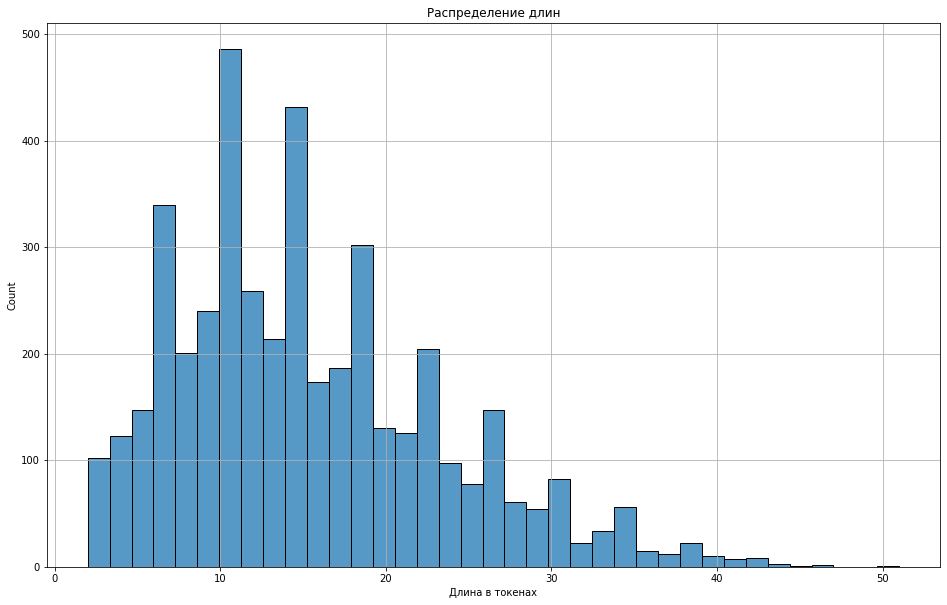

In [208]:
plt.figure(figsize=(16, 10))
plt.grid()
plt.title("Распределение длин")
plt.xlabel("Длина в токенах")
sns.histplot(lengths)

In [209]:
np.percentile(lengths, 97)

34.0

In [210]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

## Dataset and DataLoader

In [211]:
class CedrDataset(Dataset):

    def __init__(self, texts, labels, word2id, DEVICE, tokenizer, vocab, max_len=32):
        self.texts = texts
        self.labels = labels

        self.word2id = word2id
        self.device = DEVICE
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self): #это обязательный метод, он должен уметь считать длину датасета
        return len(self.texts)


    def tokenize(self, text):
      tokenized_text = self.tokenizer(text)
      
      return tokenized_text


    def indexing(self, tokenized_text):
      tokenized_text = [self.word2id[tok] if tok in self.word2id else self.word2id['UNK'] for tok in tokenized_text]

      return tokenized_text


    def padding(self, token_indices):
      token_indices = token_indices[:self.max_len]
      token_indices = F.pad(torch.LongTensor(token_indices), (0, self.max_len - len(token_indices)))

      return token_indices



    def __getitem__(self, index): #еще один обязательный метод. По индексу возвращает элемент выборки
        
        text = self.texts[index]
        target = self.labels[index]

        tokenized_text = self.tokenize(text)
        token_indices = self.indexing(tokenized_text)

        token_indices = self.padding(token_indices)
        
        ids = torch.tensor(token_indices, dtype=torch.long).to(self.device)
        target = torch.tensor(target, dtype=torch.long).to(self.device)


        return ids, target

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
        ids, target = list(zip(*batch))
        ids = torch.tensor(ids).to(self.device)
        target = torch.tensor(target).to(self.device) # tuple ([1], [0], [1])  -> Tensor [[1.], [0.], [1.]] 
        return ids, y

In [212]:
x_y = list(zip(texts, labels))
shuffle(x_y)
texts, labels = zip(*x_y)

In [213]:
train_sentences, val_sentences, train_y, val_y = train_test_split(texts, labels, test_size=0.1)

In [214]:
train_dataset = CedrDataset(texts=train_sentences, labels=train_y, word2id=word2id, DEVICE=DEVICE,
                     tokenizer=wordpunct_tokenize, vocab=vocab, max_len=32)
train_loader = DataLoader(train_dataset, batch_size=128)


In [215]:
len(train_loader)

31

In [216]:
batch = next(iter(train_loader))
batch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[tensor([[1065, 2456,   45,  ...,    0,    0,    0],
         [1982,    1,    1,  ...,    0,    0,    0],
         [   1, 1444, 2479,  ...,    1,  269, 1313],
         ...,
         [1982,    1,  965,  ...,    0,    0,    0],
         [ 685,  276, 1772,  ...,    0,    0,    0],
         [   1,  269,    1,  ...,    0,    0,    0]], device='cuda:0'),
 tensor([4, 1, 3, 1, 1, 1, 0, 1, 0, 4, 1, 0, 1, 0, 0, 2, 1, 1, 2, 0, 0, 1, 0, 1,
         2, 2, 2, 1, 4, 3, 1, 0, 0, 1, 0, 2, 1, 0, 2, 1, 0, 0, 3, 1, 2, 4, 3, 0,
         0, 0, 0, 1, 4, 1, 3, 1, 2, 4, 2, 1, 0, 0, 1, 0, 2, 1, 1, 4, 4, 3, 0, 0,
         0, 2, 0, 3, 0, 1, 2, 0, 1, 0, 2, 1, 0, 0, 0, 1, 4, 0, 0, 1, 2, 1, 0, 3,
         1, 0, 2, 1, 4, 0, 1, 0, 1, 0, 0, 3, 1, 4, 0, 0, 4, 3, 2, 4, 0, 4, 0, 0,
         3, 3, 1, 0, 2, 2, 2, 3], device='cuda:0')]

In [217]:
x, y = train_dataset[1]
x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([1982,    1,    1, 2091, 2418, 2087,    1,  817,  269, 1371,  671,  269,
         882, 1479,    1,  269,    1, 1444, 1596,    1,  269, 1785,  860,  558,
        1772,    0,    0,    0,    0,    0,    0,    0], device='cuda:0')

We can convert ids back to words to see sentences

In [218]:
[id2word[idx.item()] for idx in x]

['«',
 'UNK',
 'UNK',
 'ко',
 'мне',
 'в',
 'UNK',
 'такие',
 ',',
 'плачут',
 'девочки',
 ',',
 'что',
 'ребенка',
 'UNK',
 ',',
 'UNK',
 'и',
 'так',
 'UNK',
 ',',
 '—',
 'отметила',
 'она',
 '.',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [219]:
val_dataset = CedrDataset(texts=val_sentences, labels=val_y, word2id=word2id, DEVICE=DEVICE,
                     tokenizer=wordpunct_tokenize, vocab=vocab, max_len=32)
val_loader = DataLoader(val_dataset, batch_size=128)

In [220]:
len(val_loader)

4

## Model, training loop

In [260]:
print(f'Embedding dim should be sqrt of vocabulary size: {len(word2id)}, emd_dim: {len(word2id) ** 0.5}')

Embedding dim should be sqrt of vocabulary size: 2483, emd_dim: 49.82971001320397


In [269]:
class MLP(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()          
        # указываем в атрибутах класса, какие слои и активации нам понадобятся
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.emb2h = nn.Linear(embedding_dim, 100) 
        self.act = nn.ReLU()
        self.linear = nn.Linear(100, 200)
        self.dropout = nn.Dropout(p=0.5)
        self.h2out = nn.Linear(200, 5)
        self.act_out = nn.Softmax()
        
        
    def forward(self, text): #необходимый метод,  в нем указываем, как именно связываются слои/активации между собой
        # batch_size x seq_len
        #ipdb.set_trace()
        embedded = self.embedding(text)   # переводим последовательность индексов в последовательность эмбеддингов
        # batch_size x seq_len x embedding_dim
        
        mean_emb = torch.mean(embedded, dim=1) # считаем средний эмбеддинг предложения
        # batch_size x embedding_dim
        hidden = self.emb2h(mean_emb) # пропускаем эмбеддинг через полносвязный слой 
        # batch_size x 10
        hidden = self.act(hidden)
        # batch_size x 10
        hidden = self.dropout(hidden)
        hidden = self.linear(hidden)
        hidden = self.act(hidden)
        hidden = self.dropout(hidden)
        # batch_size x 10
        out = self.h2out(hidden) # возвращаем одно число для каждого семпла
        # batch_size x 1
        proba = self.act_out(out) # пропускаем число через сигмоиду, делая из него вероятность класса
        # batch_size x 1
        return proba

In [270]:
def train(model, iterator, optimizer, criterion):
    print('Training...')
    epoch_loss = 0 # для подсчета среднего лосса на всех батчах
    model.train()  # ставим модель в обучение, явно указываем, что сейчас надо будет хранить градиенты у всех весов

    for i, (texts, ys) in enumerate(iterator): #итерируемся по батчам
        optimizer.zero_grad()  #обнуляем градиенты
        #ipdb.set_trace()
        predictions = model(texts) #прогоняем данные через модель
        loss = criterion(predictions, ys) #считаем значение функции потерь  
        loss.backward() #считаем градиенты  
        optimizer.step() #обновляем веса 
        epoch_loss += loss.item() #сохраняем значение функции потерь
        
        if not (i + 1) % 20:
            print(f'Train loss: {epoch_loss/i}')
        
    return epoch_loss / len(iterator), predictions # возвращаем среднее значение функции потерь по всей выборке

In [271]:
def evaluate(model, iterator, criterion):
    print("\nValidating...")
    epoch_loss = 0
    model.eval() 
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            predictions = model(texts)  # делаем предсказания на тесте
            loss = criterion(predictions, ys)   # считаем значения функции ошибки для статистики  
            epoch_loss += loss.item() 
            
            if not (i + 1) % 5:
              print(f'Val loss: {epoch_loss/i}')
        
    return epoch_loss / len(iterator), predictions # возвращаем средний лосс по батчам

In [272]:
model = MLP(len(word2id), 50)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss() 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [273]:
losses = []
losses_eval = []


for i in range(20):
    print(f'\nstarting Epoch {i}')
    epoch_loss, tr_pred = train(model, train_loader, optimizer, criterion)
    losses.append(epoch_loss)

    epoch_loss_on_test, val_pred = evaluate(model, val_loader, criterion)
    losses_eval.append(epoch_loss_on_test)



starting Epoch 0
Training...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train loss: 1.647600337078697

Validating...

starting Epoch 1
Training...
Train loss: 1.5981058133275885

Validating...

starting Epoch 2
Training...
Train loss: 1.5967037175831043

Validating...

starting Epoch 3
Training...
Train loss: 1.5917626556597257

Validating...

starting Epoch 4
Training...
Train loss: 1.587576847327383

Validating...

starting Epoch 5
Training...
Train loss: 1.5711620669615896

Validating...

starting Epoch 6
Training...
Train loss: 1.5461837241524143

Validating...

starting Epoch 7
Training...
Train loss: 1.508578018138283

Validating...

starting Epoch 8
Training...
Train loss: 1.4769713000247353

Validating...

starting Epoch 9
Training...
Train loss: 1.4482195440091585

Validating...

starting Epoch 10
Training...
Train loss: 1.4272717613922923

Validating...

starting Epoch 11
Training...
Train loss: 1.4130801276156777

Validating...

starting Epoch 12
Training...
Train loss: 1.4017311271868254

Validating...

starting Epoch 13
Training...
Train loss:

## Plotted loss for train and val

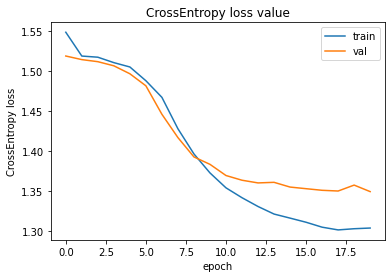

In [274]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.plot(losses_eval)
plt.title('CrossEntropy loss value')
plt.ylabel('CrossEntropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right');

In [276]:
batch, y = next(iter(val_loader))
print(len(y))

with torch.no_grad():
  preds = np.argmax(model(batch).detach().cpu().numpy(), axis=1)

128


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [277]:
from sklearn.metrics import classification_report

print(classification_report(y.detach().cpu().numpy(), preds));

              precision    recall  f1-score   support

           0       0.58      0.76      0.66        42
           1       0.54      0.93      0.68        41
           2       0.33      0.04      0.08        23
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         7

    accuracy                           0.55       128
   macro avg       0.29      0.35      0.28       128
weighted avg       0.42      0.55      0.45       128



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As we may see, our MLP classifier is too weak and simple for this task. For this batch it doesn't predict labels 3 and 4 for any text and very few 2 labels.